***
# EDA emotions_with_neutrals_220228.csv dataset
Concatenated the neutrals from Kaggle dataset with Huggingface dataset<br>
https://github.com/dair-ai/emotion_dataset<br>
https://huggingface.co/datasets/dair-ai/emotion
***

***
## 1 Load the train/test/val datasets
 <span style="color:red">!!!Make sure to comment out the correct source (Google drive or local)!!!</span>

In [1]:
import pandas as pd
import numpy as np
import random

# mount google drive
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# read from the google drive
project_folder = '/content/gdrive/MyDrive/266_Final_Project_Folder'

train_source = project_folder + '/datasets/train_data_imbalanced_stratified.csv'
test_source = project_folder + '/datasets/test_data_imbalanced_stratified.csv'
val_source = project_folder + '/datasets/validation_data_imbalanced_stratified.csv'

# Load the dfs
train_df = pd.read_csv(train_source)
test_df = pd.read_csv(test_source)
val_df = pd.read_csv(val_source)

In [3]:
# drop the tweet_id column
train_df.drop(columns=train_df.columns[0], axis=1, inplace=True)
test_df.drop(columns=test_df.columns[0], axis=1, inplace=True)
val_df.drop(columns=val_df.columns[0], axis=1, inplace=True)

In [4]:
train_df

,text,emotions
0,i know what it s like to feel empty and to be ...,sadness
1,i wanted to give it texture make it feel real ...,sadness
2,i dont know and if i feel petty and ungrateful...,anger
3,i feel like my life is really shaky right now,fear
4,i feel like some valuable social etiquette has...,joy
...,...,...
223354,i have really enjoyed the break from eastender...,joy
223355,im feeling utterly exhausted i imagine sitting...,sadness
223356,i love how girly the shade is and i always fee...,joy
223357,i can understand how they feel i m thrilled th...,joy


In [5]:
test_df

,text,emotions
0,i wait to hear her soft laugh and feel her gen...,love
1,i feel antsy and dissatisfied,anger
2,i could feel his blood pressure slowly start t...,joy
3,i have been overwhelmed with a feeling of disc...,sadness
4,i feel like i never learn anything truly usefu...,joy
...,...,...
127630,i was feeling adventurous and poured this into...,joy
127631,im feeling pretty good but once at the bus sto...,joy
127632,i really feel glad that i didnt avoid him when...,joy
127633,im feeling a bit more peaceful,joy


In [6]:
val_df

,text,emotions
0,i am feeling a bit shaken,fear
1,i feel that no matter what i do they look terr...,sadness
2,"@MRHYPERPCS Thanks, but the Elance course is n...",neutral
3,i feel a few times since judges and law clerks...,sadness
4,i have been feeling quite bitter and angry at ...,anger
...,...,...
74448,i woke up sad still feeling delicate like yest...,love
74449,i feel essentially that it s a supporting cast,love
74450,i remember feeling so calm in his presence,joy
74451,i choose to major in interior design because i...,joy


***
## 2 Tokenizer

### Find the top word count (frequency > 10)

In [7]:
# Split the text column into a list of words
words_df = train_df['text'].str.split().to_frame('words')

# Explode the list of words into separate rows
words_df = words_df.explode('words')

# Group by the words and count their occurrences
words_df = words_df.groupby('words').size().reset_index(name='count')
words_df

,words,count
0,!,35
1,!!,5
2,!!!,2
3,!!!!,1
4,!!my,1
...,...,...
66419,ï¿½6,1
66420,ï¿½Iï¿½M,1
66421,ï¿½o_0ï¿½*giggles*ï¿½who,1
66422,ï¿½tearï¿½,1


In [8]:
# find the words with 'count' > 10
condition = words_df['count'] > 10

# sort the words based on count
new_words_df = words_df[condition].sort_values('count', ascending=False)

new_words_df

,words,count
31705,i,355407
25037,feel,151992
8449,and,132152
59904,to,123853
59061,the,115099
...,...,...
12295,bodily,11
56913,strides,11
63760,wage,11
60547,translates,11


In [9]:
# how many words are > 10?
top_word_count = len(new_words_df) # 10,179 words are greater than 10 count

### Let's tokenize the train tweets!

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [11]:
tokenizer = Tokenizer(num_words=top_word_count, oov_token='<UNK>')
tokenizer.fit_on_texts(train_df['text']) # pass in tweets from training set

In [12]:
# this is what the tweet looks like as words
train_df['text'][0]

'i know what it s like to feel empty and to be happy about the feeling'

In [13]:
# this is what the tokenized version of the tweet looks like
tokenizer.texts_to_sequences([train_df['text'][0]])

[[2, 44, 50, 13, 85, 14, 5, 3, 472, 4, 5, 27, 149, 28, 6, 8]]

(array([1.0910e+03, 1.1347e+04, 1.6750e+04, 1.7445e+04, 1.7888e+04,
        2.6940e+04, 1.7135e+04, 1.5995e+04, 1.4593e+04, 1.3154e+04,
        1.6867e+04, 9.4430e+03, 7.7700e+03, 6.6560e+03, 5.5320e+03,
        4.6270e+03, 5.6070e+03, 2.9100e+03, 2.4000e+03, 1.9730e+03,
        1.6600e+03, 1.9760e+03, 1.0500e+03, 7.9200e+02, 6.3600e+02,
        4.7700e+02, 2.9000e+02, 2.2900e+02, 7.3000e+01, 2.3000e+01,
        1.2000e+01, 6.0000e+00, 3.0000e+00, 2.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

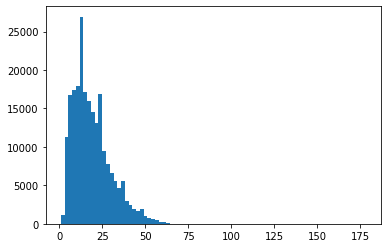

In [14]:
import matplotlib.pyplot as plt

# check to see what lenghts of the tweets in the dataset
lengths = [len(t.split(' ')) for t in train_df['text']]
plt.hist(lengths, bins=len(set(lengths)))

In [15]:
import statistics

# Apply the lambda function to the 'content' column and list called word_count_list'
word_count_list = list(train_df['text'].apply(lambda x: len(x.split(' '))))

# display the maximum and minimum lengths
print('Maximum word length:', max(word_count_list))
print('Minimum word length:', min(word_count_list))
print('Mean word length:', statistics.mean(word_count_list))
print('Median word length:', statistics.median(word_count_list))
print('75th percentile word length:', np.percentile(word_count_list, 75))
print('85th percentile word length:', np.percentile(word_count_list, 85))
print('95th percentile word length:', np.percentile(word_count_list, 95))

Maximum word length: 178
Minimum word length: 1
Mean word length: 19.04250108569612
Median word length: 17
75th percentile word length: 25.0
85th percentile word length: 30.0
95th percentile word length: 41.0


The max number of words is 178. We ultimately decided that we are going to keep all the words in the tweet. BERT can handle more than 200 so setting max_len = 200

## 3 Padding and truncating the sequences to make sure that the shape is the same for each string.

In [16]:
max_len = 200 # set the largest tweet size, >200 words -- truncate, <200 words -- pad

from tensorflow.keras.preprocessing.sequence import pad_sequences

In [17]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=max_len) # truncating happens at the end of the sequence (post)
  return padded # all examples will be the returned with same input size

In [18]:
padded_train_seq = get_sequences(tokenizer, train_df['text'])
padded_train_seq[0]

array([  2,  44,  50,  13,  85,  14,   5,   3, 472,   4,   5,  27, 149,
        28,   6,   8,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

## 4 Convert labels to numeric

### Function to convert text labels to numeric (reuse for train, test, val)

In [19]:
def convert_labels_to_numeric(data):
  classes = set(data)

  # convert class to index
  c_to_i = dict((c, i) for i, c in enumerate(classes))
  i_to_c = dict((v, k) for k, v in c_to_i.items())
  
  return c_to_i

In [20]:
class_to_index_train = convert_labels_to_numeric(train_df['emotions'])
class_to_index_train

{'joy': 0,
 'surprise': 1,
 'fear': 2,
 'love': 3,
 'sadness': 4,
 'neutral': 5,
 'anger': 6}

In [21]:
def names_to_ids(class_to_index, data):
  return np.array([class_to_index.get(x) for x in data])

In [22]:
# confirming if it worked (change index) and they should line up with above dict
index = 7
train_labels = names_to_ids(class_to_index_train, train_df['emotions'])
print('train_df.iloc[7]:\n', train_df.iloc[index])
print('numeric label:', train_labels[index])

train_df.iloc[7]:
 text        i mean literally just posting lists of my acti...
emotions                                             surprise
Name: 7, dtype: object
numeric label: 1


## 5 Create the model

In [23]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
# import nlp
import random


def show_history(h):
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    
def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.11.0


In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=10179, output_dim=8, input_length=max_len),
    
    # the RNN part of the model
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, return_sequences=True)), # since using an LSTM layer inside a bidrectional layer, context can go in either direction; return_sequences=True means at every time step, there is an output
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10, )),

    tf.keras.layers.Dense(7, activation='softmax') # 7 for the six classes

])

model.compile(
    loss='sparse_categorical_crossentropy', # since this is a multiclass classification problem, use categorical crossentropy; since classes are integers (not one hot encoded/binary), use sparse (just like in A3)
    optimizer='adam',
    metrics=['accuracy']
)

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 8)            81432     
                                                                 
 bidirectional (Bidirectiona  (None, 20)               1520      
 l)                                                              
                                                                 
 dense (Dense)               (None, 7)                 147       
                                                                 
Total params: 83,099
Trainable params: 83,099
Non-trainable params: 0
_________________________________________________________________


## 6 Train the model

### Convert the labels of the validation set to numeric (just like the training set

In [26]:
class_to_index_val = convert_labels_to_numeric(val_df['emotions'])
class_to_index_val

{'joy': 0,
 'surprise': 1,
 'fear': 2,
 'love': 3,
 'sadness': 4,
 'neutral': 5,
 'anger': 6}

In [27]:
val_seq = get_sequences(tokenizer, val_df['text'])
val_labels = names_to_ids(class_to_index_val, val_df['emotions'])

In [28]:
val_seq[0], val_df['text'][0], val_df['emotions'][0]

(array([  2,  24,   8,   7,  88, 749,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0

In [29]:
print('val_df.iloc[0]:\n', val_df.iloc[0])
print('numeric label:', val_labels[0])

val_df.iloc[0]:
 text        i am feeling a bit shaken
emotions                         fear
Name: 0, dtype: object
numeric label: 2


#### Check out the shape to make sure they're as expected

In [30]:
padded_train_seq.shape

(223359, 200)

In [31]:
train_labels.shape

(223359,)

In [32]:
val_seq.shape

(74453, 200)

In [33]:
val_labels.shape

(74453,)

### From Natalie's Notebook
https://github.com/datasci-w266/2023-spring-main/blob/master/materials/walkthrough_notebooks/keras_with_limited_ram/keras_training_with_limited_ram.ipynb<br><br>
https://edstem.org/us/courses/32607/discussion/2699088?comment=6229916

#### Inspired by Natalie's notebook, made my own generator that chunks up my data into pieces that won't make my machine run out of memory before completing one epoch

In [34]:
# Define a generator function
def generator(data, labels, batch_size):
    num_samples = len(data)
    while True:
        indices = np.random.randint(num_samples, size=batch_size)
        yield data[indices], labels[indices]

In [35]:
# Create the generator
batch_size = 6 # using batch size 6 because that's what seemed reasonable based on the number of records in the training dataset
gen = generator(data=padded_train_seq, labels=train_labels, batch_size=batch_size)

In [36]:
!ls '/content/gdrive/MyDrive/266_Final_Project_Folder/cm_working_dir/cm_checkpoints/'

In [37]:
checkpoint_dir = project_folder + '/cm_working_dir/cm_checkpoints'
checkpoint_filepath = checkpoint_dir + '/weights.{epoch:02d}-{val_accuracy:.2f}.hdf5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True)

In [38]:
print(checkpoint_filepath)

/content/gdrive/MyDrive/266_Final_Project_Folder/cm_working_dir/cm_checkpoints/weights.{epoch:02d}-{val_accuracy:.2f}.hdf5


### Training the Model!!!

In [39]:
# uncomment below when loading checkpoints
# hdf5_checkpoint = 'weights.05-0.75.hdf5' # change this to the right filename for the checkpoint
# checkpoint_filepath = checkpoint_dir + 'weights.05-0.93.hdf5'
# model.load_weights(checkpoint_filepath)

In [40]:
steps_per_epoch = len(padded_train_seq) // batch_size

history = model.fit(
    gen,
    validation_data=(val_seq, val_labels),
    steps_per_epoch=steps_per_epoch,
    epochs=5,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2), # if model doesn't see improvement in val_accuracy after 2 epochs, it will stop training
        model_checkpoint_callback
    ]
)

Epoch 1/5
37226/37226 [==============================] - 664s 18ms/step - loss: 0.3780 - accuracy: 0.8606 - val_loss: 0.2011 - val_accuracy: 0.9143
Epoch 2/5
37226/37226 [==============================] - 627s 17ms/step - loss: 0.1394 - accuracy: 0.9338 - val_loss: 0.1481 - val_accuracy: 0.9249
Epoch 3/5
37226/37226 [==============================] - 610s 16ms/step - loss: 0.1176 - accuracy: 0.9395 - val_loss: 0.1364 - val_accuracy: 0.9276
Epoch 4/5
37226/37226 [==============================] - 591s 16ms/step - loss: 0.1066 - accuracy: 0.9434 - val_loss: 0.1298 - val_accuracy: 0.9264
Epoch 5/5
37226/37226 [==============================] - 586s 16ms/step - loss: 0.1006 - accuracy: 0.9458 - val_loss: 0.1304 - val_accuracy: 0.9266


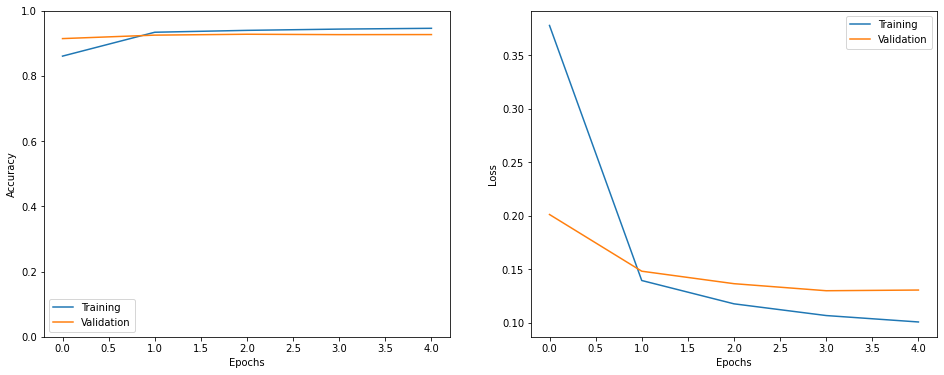

In [41]:
show_history(history)

## 7 Evaluate the model using test_df

In [42]:
padded_test_seq = get_sequences(tokenizer, test_df['text'])
padded_test_seq[0]

array([   2,  809,    5,  381,   66, 1508, 1128,    4,    3,   66,  562,
        511,   29,   11, 1979,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [43]:
class_to_index_test = convert_labels_to_numeric(test_df['emotions'])
class_to_index_test

{'joy': 0,
 'surprise': 1,
 'fear': 2,
 'love': 3,
 'sadness': 4,
 'neutral': 5,
 'anger': 6}

In [44]:
# confirming if it worked (change index) and they should line up with above dict
index = 7
test_labels = names_to_ids(class_to_index_test, test_df['emotions'])
print('test_df.iloc[7]:\n', test_df.iloc[index])
print('numeric label:', test_labels[index])

test_df.iloc[7]:
 text        i feel awkward annoying and unwanted pagetitle...
emotions                                              sadness
Name: 7, dtype: object
numeric label: 4


### Evaluating the model!!!

In [45]:
_ = model.evaluate(padded_test_seq, test_labels)

3989/3989 [==============================] - 32s 8ms/step - loss: 0.1286 - accuracy: 0.9286


### Find random records, print, then predict and see if the prediction matches the label

In [66]:
i = random.randint(0, len(test_labels) - 1)

print('Sentence:', test_df.iloc[i])
print('Emotion:', test_labels[i]) #index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(padded_test_seq[i], axis=0))[0]
pred_class = np.argmax(p).astype('uint8')

print('Predicted Emotion:', pred_class)

Sentence: text        i feel it i know what i feel is real but i m n...
emotions                                                  joy
Name: 41559, dtype: object
Emotion: 0
1/1 [==============================] - 0s 48ms/step
Predicted Emotion: 0
